In [1]:
import pandas as pd
import numpy as np
import torch
import os
import joblib
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import DataParallel, MSELoss
from torch.optim import AdamW
from tqdm.notebook import tqdm
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import LinearSVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

In [2]:
# Setting random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [3]:
class TabularDataset(Dataset):
    
    def __init__(self, df, numeric_features, cat_features):
        self.numeric_features = torch.tensor(df[numeric_features].values)
        self.cat_features = torch.LongTensor(df[cat_features].values)
        self.fares = torch.tensor(df["Fare"].values)
    
    def __getitem__(self, idx):
        return self.numeric_features[idx], self.cat_features[idx], self.fares[idx]
    
    
    def __len__(self):
        return len(self.fares)        

In [4]:
year = 2021
df = pd.read_csv(os.path.join(str(year), "./chicago_taxi_cleaned.csv"))
print("There are {} data points".format(len(df)))
df.columns

There are 3299523 data points


Index(['Trip ID', 'Taxi ID', 'Trip Start Timestamp', 'Trip End Timestamp',
       'Trip Seconds', 'Trip Miles', 'Pickup Census Tract',
       'Dropoff Census Tract', 'Pickup Community Area',
       'Dropoff Community Area', 'Fare', 'Tips', 'Tolls', 'Extras',
       'Trip Total', 'Payment Type', 'Company', 'Pickup Centroid Latitude',
       'Pickup Centroid Longitude', 'Pickup Centroid Location',
       'Dropoff Centroid Latitude', 'Dropoff Centroid Longitude',
       'Dropoff Centroid  Location'],
      dtype='object')

In [5]:
# Encoding categorical variables

from datetime import datetime, timedelta

def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta


def encode_cat_variables(df):

    
    # Converting to datetime format
    
    dtformat = "%m/%d/%Y %I:%M:%S %p"
    tformat = '%H:%M:%S'
    dformat = "%m/%d/%Y"

    df["Trip Start Timestamp"] = pd.to_datetime(df["Trip Start Timestamp"], format=dtformat)
    df["Trip End Timestamp"] = pd.to_datetime(df["Trip End Timestamp"], format=dtformat)
    
    df["Trip Start Time"] = df["Trip Start Timestamp"].dt.time.astype('str')
    df["Trip End Time"] = df["Trip End Timestamp"].dt.time.astype('str')

    df['month'] = df['Trip Start Timestamp'].dt.month
    df['weekday'] = df['Trip Start Timestamp'].dt.day_name()
    
    # Encoding date time information
    
    # There are 96 15-minutes interval from 00:00 to 23:45
    time_encoder = LabelEncoder().fit([dt.strftime('%H:%M:%S') for dt in 
           datetime_range(datetime(2016, 9, 1, 0), datetime(2016, 9, 1, 23, 59), 
           timedelta(minutes=15))])
    
    df["Trip Start Time"] = time_encoder.transform(df["Trip Start Time"]) / 95
    df["Trip End Time"] = time_encoder.transform(df["Trip End Time"]) / 95
    
    # Encoding month and day of the week
    month_encoder = LabelEncoder().fit(np.arange(1, 13))
    df['month'] = LabelEncoder().fit(np.arange(1, 13)).transform(df['month'])
    df['weekday'] = LabelEncoder().fit(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 
                                        'Saturday', 'Sunday']).transform(df['weekday'])
                                        
    df["Pickup Community Area"] = df["Pickup Community Area"].fillna(78).astype('int')
    df["Dropoff Community Area"] = df["Dropoff Community Area"].fillna(78).astype('int')

    df["Payment Type"] = df["Payment Type"].fillna('Unknown')
    df["Payment Type"] = LabelEncoder().fit(['Cash', 'Unknown', 'Credit Card', 'Prcard', 'Mobile'])\
        .transform(df["Payment Type"])
    
    return df
    

In [6]:
df = encode_cat_variables(df)

In [7]:
df.head()

,Trip ID,Taxi ID,Trip Start Timestamp,Trip End Timestamp,Trip Seconds,Trip Miles,Pickup Census Tract,Dropoff Census Tract,Pickup Community Area,Dropoff Community Area,...,Pickup Centroid Latitude,Pickup Centroid Longitude,Pickup Centroid Location,Dropoff Centroid Latitude,Dropoff Centroid Longitude,Dropoff Centroid Location,Trip Start Time,Trip End Time,month,weekday
0,02fc5d8c3e8525a49b7514bd6c2b3301c2d6aa79,7e179f8ef66ae99ec2d1ec89224e0b7ee5469fe5627f6d...,2021-01-01,2021-01-01 00:15:00,1021.0,3.17,NaN,NaN,78,4,...,NaN,NaN,NaN,41.975171,-87.687516,POINT (-87.6875155152 41.9751709433),0.0,0.010526,0,0
1,4bcfcfa78f372b705214ee2cba9c765ad6ba5161,31261f6e7fc645eff98c7964c7ea71a0ea7e387a6bd7f8...,2021-01-01,2021-01-01 00:00:00,120.0,0.10,NaN,NaN,8,8,...,41.899602,-87.633308,POINT (-87.6333080367 41.899602111),41.899602,-87.633308,POINT (-87.6333080367 41.899602111),0.0,0.000000,0,0
2,820a917a49280f0ee5ba61802ae5d13c55bf51ed,7476a493f34aa1075570e89104cdaf3aaf5c0fd4679382...,2021-01-01,2021-01-01 00:15:00,960.0,10.60,NaN,NaN,33,78,...,41.857184,-87.620335,POINT (-87.6203346241 41.8571838585),NaN,NaN,NaN,0.0,0.010526,0,0
3,855259d1bc129f6370f038aa910067972eeae037,0aba795cd29b34ff868043bc923a341f37c4f6d7afabe4...,2021-01-01,2021-01-01 00:15:00,900.0,0.30,NaN,NaN,28,22,...,41.874005,-87.663518,POINT (-87.6635175498 41.874005383),41.922761,-87.699155,POINT (-87.6991553432 41.9227606205),0.0,0.010526,0,0
4,88194fab0a0a28df1b87e9f358143197d004d4d9,e11ecc8e74a2d3cbd2e9f58151ed09c81587cb491c50f6...,2021-01-01,2021-01-01 00:15:00,1140.0,4.30,NaN,NaN,6,4,...,41.944227,-87.655998,POINT (-87.6559981815 41.9442266014),41.975171,-87.687516,POINT (-87.6875155152 41.9751709433),0.0,0.010526,0,0


In [8]:
# We set aside 30% of the data to be the test set 
# Then we further split 25% of the remaining data to be the validation set

train_val_df, test_df = train_test_split(df, test_size=0.3)
train_df, val_df = train_test_split(train_val_df, test_size=0.25)

print(len(train_df), len(val_df), len(test_df))

1732249 577417 989857


In [9]:
# 5 payment type variables
# 78 community type variables
# 12 months
# 7 days in a week

numerical_features = ['Trip Miles', 'Trip Seconds', 'Trip Start Time', 'Trip End Time']
cat_features = ['Pickup Community Area', 'Dropoff Community Area', 'Payment Type', 'month', 'weekday']

normalizer = StandardScaler().fit(train_df[numerical_features])
train_df.loc[:, numerical_features] = normalizer.transform(train_df[numerical_features]).astype('float32')
val_df.loc[:, numerical_features] = normalizer.transform(val_df[numerical_features]).astype('float32')
test_df.loc[:, numerical_features] = normalizer.transform(test_df[numerical_features]).astype('float32')

In [10]:
joblib.dump(normalizer, "./scaler.joblib")

['../scaler.joblib']

In [10]:
num_workers = 25
batch_size = 512

train_ds = TabularDataset(train_df, numerical_features, cat_features)
val_ds = TabularDataset(val_df, numerical_features, cat_features)
test_ds = TabularDataset(test_df, numerical_features, cat_features)

train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [11]:
class FarePredictor(nn.Module):
    
    def __init__(self, numeric_features, embedding_in_channels, embedding_out_channels, hidden_layers):
        super(FarePredictor, self).__init__()
        self.numeric_features = numeric_features
        self.embedding_in_channels = embedding_in_channels
        self.embedding_out_channels = embedding_out_channels
        
        self.embedding_layers = nn.ModuleList([nn.Embedding(in_channel, out_channel) for in_channel, out_channel
                                               in zip(embedding_in_channels, embedding_out_channels)])
        
        in_channel = len(numeric_features) + np.sum(embedding_out_channels)
        self.layers = []
        for out_channel in hidden_layers:
            self.layers.append(nn.Linear(in_channel, out_channel))
            self.layers.append(nn.BatchNorm1d(out_channel))
            self.layers.append(nn.ReLU())
            in_channel = out_channel
        self.layers.append(nn.Linear(out_channel, 1))
        self.layers = nn.Sequential(*self.layers)
    
    def forward(self, numeric_features, cat_features):
        cat_features = torch.cat([embedding_layer(cat_feature.squeeze(1)) for embedding_layer, cat_feature in
                                  zip(self.embedding_layers, cat_features.split(1, dim=1))], dim=1)
        features = torch.cat([numeric_features, cat_features], dim=1).float()
        return self.layers(features)

In [54]:
from time import time
from sklearn.metrics import mean_squared_error, mean_absolute_error

def update_metric(running_metric, curr_metric, smoothing_factor=0.9):
    if running_metric == 0:
        return curr_metric
    else:
        return smoothing_factor * running_metric + (1 - smoothing_factor) * curr_metric
    
    
def print_clf_metrics(train_stats, val_stats, curr_epoch, total_epochs):
                      

    print("Epoch:[{epoch}/{n_epoch}]".format(epoch=curr_epoch, n_epoch=total_epochs))

    train_results = ""
    for metric, result in train_stats.items():
        train_results += "{}:{:.3f} \t ".format(metric, result)
    
    print(train_results)

    val_results = ""
    for metric, result in val_stats.items():
        val_results += "{}:{:.3f} \t ".format(metric, result)
    
    print(val_results)
    
    print("=====================================")
    
    
def train_classification_one_epoch(model, train_dl, criterion,
                                   optimizer, device):
    
    start = time()
    running_loss = 0 
    running_mae = 0
    running_rmse = 0
    
    model.train()
    
    for _, data in tqdm(enumerate(train_dl), total=len(train_dl)):
        
        num_features, cat_features, labels = data
        
        num_features = num_features.to(device)
        cat_features = cat_features.to(device)
        labels = labels.to(device)
            
        outputs = model(num_features, cat_features)
        loss = criterion(outputs.squeeze(1), labels.float())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0).item()
        optimizer.step()
        optimizer.zero_grad()
        
        labels = labels.detach().cpu().numpy()
        outputs = outputs.squeeze(1).detach().cpu().numpy()
        
        running_loss = update_metric(running_loss, loss.detach().cpu().item(), smoothing_factor=0.99)
        running_mae = update_metric(running_mae, mean_absolute_error(labels, outputs))
        running_rmse = update_metric(running_rmse, mean_squared_error(labels, outputs, 
                                                                      squared=False))
    train_time = time() - start
    
    return {'Train Loss': running_loss,
            'Train MAE': running_mae,
            'Train RMSE': running_rmse,
            'Train Time': train_time}


def validate(model, val_dl, criterion, device):
    
    start = time()
    
    val_loss = []
    val_outs = []
    val_labels = []
    
    model.eval()

    with torch.no_grad():
        for _, data in enumerate(val_dl):
            num_features, cat_features, labels = data
            
            num_features = num_features.to(device)
            cat_features = cat_features.to(device)
            labels = labels.to(device)
            
            outputs = model(num_features, cat_features)
            val_loss.append(criterion(outputs.squeeze(1), labels.float()).detach().cpu().item())
            
            outputs = outputs.squeeze(1).detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            val_outs = np.append(val_outs, outputs)
            val_labels = np.append(val_labels, labels)
            
    compute_time = time() - start
    val_loss = np.mean(val_loss)
    val_mae = mean_absolute_error(val_labels, val_outs)
    val_rmse = mean_squared_error(val_labels, val_outs, squared=False)
    
    return {'Val Loss': val_loss,
            'Val MAE': val_mae,
            'Val RMSE': val_rmse,
            'Val Time': compute_time}


def train(model, train_dl, val_dl, criterion,
          optimizer, total_epochs, device, model_save_dir, 
          save_iter=5, resume_epoch=0):

    all_train_loss = []
    all_val_loss = []
    
    start_epoch = 1 if resume_epoch == 0 else resume_epoch
    for epoch in range(start_epoch, total_epochs + 1):  # loop over the dataset multiple times
        
        train_stats = train_classification_one_epoch(model, train_dl, criterion, optimizer, device)
        val_stats = validate(model, val_dl, criterion, device)

        train_loss = train_stats['Train Loss']
        val_loss = val_stats['Val Loss']
        
        print_clf_metrics(train_stats, val_stats, epoch, total_epochs)

        all_train_loss.append(train_loss)
        all_val_loss.append(val_loss)
        
        if epoch % save_iter == 0:
            check_point = {'epoch': epoch, 'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 
                           'Train Loss': all_train_loss, 'Val Loss': all_val_loss}

            save_path = os.path.join(model_save_dir, str(epoch))
            os.makedirs(save_path)
            torch.save(check_point, os.path.join(save_path, "checkpoint_{}.pth".format(epoch)))

    return np.array(all_train_loss), np.array(all_val_loss)

In [13]:
# 5 payment type variables
# 79 community type variables
# 12 months
# 7 days in a week

embedding_in_channels = [79, 79, 5, 12, 7]
embedding_out_channels = [2, 2, 2, 2, 2]
hidden_layers = [32, 64, 32]

    
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1, 2, 3"
device = 'cuda'

model = FarePredictor(numerical_features, embedding_in_channels, embedding_out_channels, hidden_layers)
model = nn.DataParallel(model).to(device)

optim = AdamW(model.parameters(), lr=4e-4, weight_decay=4e-5)

In [14]:
save_dir = "./nn_model_dir/"
if not os.path.exists(save_dir):
    os.mkdir(save_dir)


train_loss, val_loss = train(model, train_dl, val_dl, MSELoss(), optim, 30, device, save_dir,
                             save_iter=1)

  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[1/30]
Train Loss:14.537 	 Train MAE:1.959 	 Train RMSE:3.704 	 Train Time:99.919 	 
Val Loss:12.893 	 Val MAE:1.553 	 Val RMSE:3.591 	 Val Time:18.990 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[2/30]
Train Loss:13.167 	 Train MAE:1.885 	 Train RMSE:3.665 	 Train Time:95.750 	 
Val Loss:11.747 	 Val MAE:1.494 	 Val RMSE:3.427 	 Val Time:19.237 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[3/30]
Train Loss:12.130 	 Train MAE:1.673 	 Train RMSE:3.425 	 Train Time:94.158 	 
Val Loss:10.912 	 Val MAE:1.303 	 Val RMSE:3.303 	 Val Time:19.227 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[4/30]
Train Loss:11.274 	 Train MAE:1.557 	 Train RMSE:3.260 	 Train Time:94.581 	 
Val Loss:10.226 	 Val MAE:1.201 	 Val RMSE:3.198 	 Val Time:19.969 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[5/30]
Train Loss:10.846 	 Train MAE:1.574 	 Train RMSE:3.220 	 Train Time:93.892 	 
Val Loss:10.828 	 Val MAE:1.480 	 Val RMSE:3.291 	 Val Time:18.997 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[6/30]
Train Loss:10.781 	 Train MAE:1.509 	 Train RMSE:3.404 	 Train Time:97.238 	 
Val Loss:9.409 	 Val MAE:1.195 	 Val RMSE:3.067 	 Val Time:19.065 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[7/30]
Train Loss:9.586 	 Train MAE:1.364 	 Train RMSE:2.910 	 Train Time:95.098 	 
Val Loss:9.943 	 Val MAE:1.340 	 Val RMSE:3.153 	 Val Time:19.038 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[8/30]
Train Loss:9.789 	 Train MAE:1.426 	 Train RMSE:3.034 	 Train Time:94.118 	 
Val Loss:9.235 	 Val MAE:1.242 	 Val RMSE:3.039 	 Val Time:19.288 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[9/30]
Train Loss:9.414 	 Train MAE:1.381 	 Train RMSE:2.882 	 Train Time:95.309 	 
Val Loss:8.841 	 Val MAE:1.123 	 Val RMSE:2.974 	 Val Time:19.216 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[10/30]
Train Loss:9.351 	 Train MAE:1.344 	 Train RMSE:2.931 	 Train Time:95.753 	 
Val Loss:9.265 	 Val MAE:1.214 	 Val RMSE:3.044 	 Val Time:19.254 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[11/30]
Train Loss:9.545 	 Train MAE:1.371 	 Train RMSE:3.132 	 Train Time:94.823 	 
Val Loss:8.697 	 Val MAE:1.122 	 Val RMSE:2.949 	 Val Time:19.065 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[12/30]
Train Loss:9.326 	 Train MAE:1.358 	 Train RMSE:3.080 	 Train Time:93.904 	 
Val Loss:8.893 	 Val MAE:1.191 	 Val RMSE:2.982 	 Val Time:19.630 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[13/30]
Train Loss:9.371 	 Train MAE:1.348 	 Train RMSE:3.011 	 Train Time:94.710 	 
Val Loss:8.464 	 Val MAE:1.074 	 Val RMSE:2.909 	 Val Time:19.954 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[14/30]
Train Loss:8.839 	 Train MAE:1.217 	 Train RMSE:2.724 	 Train Time:93.984 	 
Val Loss:8.424 	 Val MAE:1.050 	 Val RMSE:2.902 	 Val Time:19.050 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[15/30]
Train Loss:8.415 	 Train MAE:1.248 	 Train RMSE:2.765 	 Train Time:94.770 	 
Val Loss:8.403 	 Val MAE:1.061 	 Val RMSE:2.899 	 Val Time:18.950 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[16/30]
Train Loss:8.569 	 Train MAE:1.258 	 Train RMSE:2.834 	 Train Time:93.318 	 
Val Loss:9.077 	 Val MAE:1.230 	 Val RMSE:3.013 	 Val Time:19.160 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[17/30]
Train Loss:8.627 	 Train MAE:1.290 	 Train RMSE:2.853 	 Train Time:97.023 	 
Val Loss:8.182 	 Val MAE:1.046 	 Val RMSE:2.861 	 Val Time:19.090 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[18/30]
Train Loss:9.127 	 Train MAE:1.326 	 Train RMSE:2.935 	 Train Time:94.956 	 
Val Loss:8.205 	 Val MAE:1.103 	 Val RMSE:2.865 	 Val Time:19.660 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[19/30]
Train Loss:8.854 	 Train MAE:1.200 	 Train RMSE:2.642 	 Train Time:94.952 	 
Val Loss:8.572 	 Val MAE:1.160 	 Val RMSE:2.928 	 Val Time:18.767 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[20/30]
Train Loss:8.702 	 Train MAE:1.225 	 Train RMSE:2.882 	 Train Time:95.722 	 
Val Loss:8.368 	 Val MAE:1.127 	 Val RMSE:2.893 	 Val Time:19.058 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[21/30]
Train Loss:8.318 	 Train MAE:1.222 	 Train RMSE:2.648 	 Train Time:93.182 	 
Val Loss:8.021 	 Val MAE:1.050 	 Val RMSE:2.832 	 Val Time:19.165 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[22/30]
Train Loss:9.365 	 Train MAE:1.328 	 Train RMSE:3.244 	 Train Time:93.670 	 
Val Loss:8.521 	 Val MAE:1.147 	 Val RMSE:2.919 	 Val Time:18.936 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[23/30]
Train Loss:8.176 	 Train MAE:1.235 	 Train RMSE:2.734 	 Train Time:94.762 	 
Val Loss:7.962 	 Val MAE:0.995 	 Val RMSE:2.822 	 Val Time:19.512 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[24/30]
Train Loss:8.643 	 Train MAE:1.219 	 Train RMSE:2.898 	 Train Time:96.050 	 
Val Loss:8.116 	 Val MAE:1.106 	 Val RMSE:2.849 	 Val Time:19.173 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[25/30]
Train Loss:8.297 	 Train MAE:1.251 	 Train RMSE:2.805 	 Train Time:95.293 	 
Val Loss:8.626 	 Val MAE:1.243 	 Val RMSE:2.937 	 Val Time:19.148 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[26/30]
Train Loss:7.800 	 Train MAE:1.175 	 Train RMSE:2.637 	 Train Time:95.033 	 
Val Loss:8.552 	 Val MAE:1.214 	 Val RMSE:2.924 	 Val Time:19.013 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[27/30]
Train Loss:8.454 	 Train MAE:1.220 	 Train RMSE:2.806 	 Train Time:96.066 	 
Val Loss:7.902 	 Val MAE:1.072 	 Val RMSE:2.811 	 Val Time:19.371 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[28/30]
Train Loss:8.350 	 Train MAE:1.290 	 Train RMSE:2.932 	 Train Time:95.181 	 
Val Loss:11.180 	 Val MAE:1.795 	 Val RMSE:3.344 	 Val Time:19.347 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[29/30]
Train Loss:8.269 	 Train MAE:1.167 	 Train RMSE:2.775 	 Train Time:95.500 	 
Val Loss:7.737 	 Val MAE:0.983 	 Val RMSE:2.782 	 Val Time:19.874 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[30/30]
Train Loss:8.024 	 Train MAE:1.169 	 Train RMSE:2.618 	 Train Time:96.150 	 
Val Loss:7.704 	 Val MAE:1.009 	 Val RMSE:2.776 	 Val Time:19.592 	 


In [15]:
import matplotlib.pyplot as plt

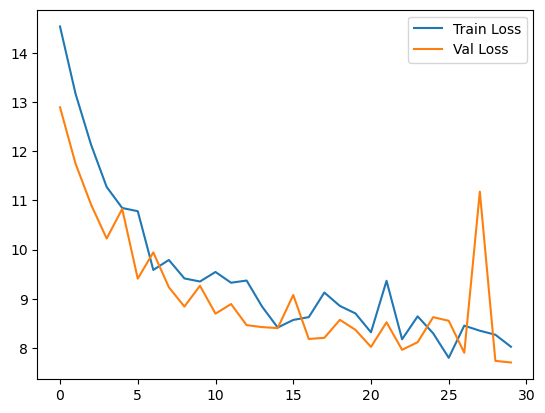

In [16]:
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()

Let's train this for 30 more epochs

In [24]:
resume_epoch = 31
train_loss, val_loss = train(model, train_dl, val_dl, MSELoss(), optim, 60, device, save_dir,
                             save_iter=1, resume_epoch=resume_epoch)

  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[31/60]
Train Loss:8.692 	 Train MAE:1.263 	 Train RMSE:3.005 	 Train Time:95.622 	 
Val Loss:7.711 	 Val MAE:1.020 	 Val RMSE:2.777 	 Val Time:18.902 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[32/60]
Train Loss:8.155 	 Train MAE:1.135 	 Train RMSE:2.639 	 Train Time:95.474 	 
Val Loss:7.935 	 Val MAE:1.021 	 Val RMSE:2.817 	 Val Time:19.510 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[33/60]
Train Loss:8.185 	 Train MAE:1.293 	 Train RMSE:2.747 	 Train Time:95.096 	 
Val Loss:8.904 	 Val MAE:1.295 	 Val RMSE:2.984 	 Val Time:19.507 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[34/60]
Train Loss:8.123 	 Train MAE:1.210 	 Train RMSE:2.841 	 Train Time:94.505 	 
Val Loss:7.806 	 Val MAE:1.040 	 Val RMSE:2.794 	 Val Time:19.910 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[35/60]
Train Loss:8.731 	 Train MAE:1.154 	 Train RMSE:2.785 	 Train Time:95.056 	 
Val Loss:8.148 	 Val MAE:1.163 	 Val RMSE:2.855 	 Val Time:19.069 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[36/60]
Train Loss:8.644 	 Train MAE:1.248 	 Train RMSE:3.049 	 Train Time:94.872 	 
Val Loss:7.638 	 Val MAE:1.003 	 Val RMSE:2.764 	 Val Time:19.964 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[37/60]
Train Loss:7.936 	 Train MAE:1.135 	 Train RMSE:2.641 	 Train Time:95.173 	 
Val Loss:7.722 	 Val MAE:1.000 	 Val RMSE:2.779 	 Val Time:21.958 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[38/60]
Train Loss:8.204 	 Train MAE:1.157 	 Train RMSE:2.677 	 Train Time:94.290 	 
Val Loss:9.041 	 Val MAE:1.314 	 Val RMSE:3.007 	 Val Time:19.630 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[39/60]
Train Loss:8.311 	 Train MAE:1.250 	 Train RMSE:3.073 	 Train Time:93.782 	 
Val Loss:8.111 	 Val MAE:1.174 	 Val RMSE:2.848 	 Val Time:19.284 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[40/60]
Train Loss:8.033 	 Train MAE:1.199 	 Train RMSE:2.944 	 Train Time:94.324 	 
Val Loss:8.047 	 Val MAE:1.119 	 Val RMSE:2.836 	 Val Time:19.378 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[41/60]
Train Loss:8.339 	 Train MAE:1.198 	 Train RMSE:2.770 	 Train Time:94.265 	 
Val Loss:7.817 	 Val MAE:1.047 	 Val RMSE:2.796 	 Val Time:19.281 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[42/60]
Train Loss:7.929 	 Train MAE:1.124 	 Train RMSE:2.500 	 Train Time:94.485 	 
Val Loss:7.599 	 Val MAE:1.001 	 Val RMSE:2.757 	 Val Time:22.138 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[43/60]
Train Loss:8.095 	 Train MAE:1.143 	 Train RMSE:2.659 	 Train Time:95.203 	 
Val Loss:7.538 	 Val MAE:0.959 	 Val RMSE:2.746 	 Val Time:19.610 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[44/60]
Train Loss:8.530 	 Train MAE:1.210 	 Train RMSE:2.823 	 Train Time:94.883 	 
Val Loss:7.496 	 Val MAE:0.976 	 Val RMSE:2.738 	 Val Time:19.582 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[45/60]
Train Loss:8.230 	 Train MAE:1.191 	 Train RMSE:3.089 	 Train Time:95.757 	 
Val Loss:7.998 	 Val MAE:1.069 	 Val RMSE:2.828 	 Val Time:19.202 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[46/60]
Train Loss:8.029 	 Train MAE:1.098 	 Train RMSE:2.653 	 Train Time:94.308 	 
Val Loss:7.657 	 Val MAE:1.026 	 Val RMSE:2.767 	 Val Time:19.443 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[47/60]
Train Loss:8.386 	 Train MAE:1.200 	 Train RMSE:2.939 	 Train Time:93.009 	 
Val Loss:7.929 	 Val MAE:1.125 	 Val RMSE:2.816 	 Val Time:19.576 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[48/60]
Train Loss:7.956 	 Train MAE:1.122 	 Train RMSE:2.482 	 Train Time:93.725 	 
Val Loss:8.174 	 Val MAE:1.204 	 Val RMSE:2.858 	 Val Time:19.208 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[49/60]
Train Loss:7.801 	 Train MAE:1.182 	 Train RMSE:2.675 	 Train Time:94.328 	 
Val Loss:7.754 	 Val MAE:1.047 	 Val RMSE:2.785 	 Val Time:19.070 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[50/60]
Train Loss:7.764 	 Train MAE:1.150 	 Train RMSE:2.602 	 Train Time:92.883 	 
Val Loss:7.586 	 Val MAE:1.002 	 Val RMSE:2.754 	 Val Time:18.955 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[51/60]
Train Loss:7.851 	 Train MAE:1.188 	 Train RMSE:2.863 	 Train Time:93.567 	 
Val Loss:9.150 	 Val MAE:1.388 	 Val RMSE:3.025 	 Val Time:19.012 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[52/60]
Train Loss:8.620 	 Train MAE:1.262 	 Train RMSE:3.273 	 Train Time:93.634 	 
Val Loss:8.283 	 Val MAE:1.187 	 Val RMSE:2.878 	 Val Time:19.295 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[53/60]
Train Loss:8.633 	 Train MAE:1.192 	 Train RMSE:2.992 	 Train Time:95.328 	 
Val Loss:8.371 	 Val MAE:1.243 	 Val RMSE:2.893 	 Val Time:19.105 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[54/60]
Train Loss:7.709 	 Train MAE:1.146 	 Train RMSE:2.728 	 Train Time:93.836 	 
Val Loss:7.351 	 Val MAE:0.940 	 Val RMSE:2.711 	 Val Time:19.240 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[55/60]
Train Loss:8.197 	 Train MAE:1.232 	 Train RMSE:3.146 	 Train Time:93.221 	 
Val Loss:8.120 	 Val MAE:1.133 	 Val RMSE:2.849 	 Val Time:19.088 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[56/60]
Train Loss:8.056 	 Train MAE:1.065 	 Train RMSE:2.520 	 Train Time:94.841 	 
Val Loss:8.039 	 Val MAE:1.134 	 Val RMSE:2.835 	 Val Time:18.312 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[57/60]
Train Loss:8.521 	 Train MAE:1.185 	 Train RMSE:2.836 	 Train Time:92.227 	 
Val Loss:7.537 	 Val MAE:1.013 	 Val RMSE:2.745 	 Val Time:18.364 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[58/60]
Train Loss:7.859 	 Train MAE:1.118 	 Train RMSE:2.680 	 Train Time:92.167 	 
Val Loss:8.160 	 Val MAE:1.154 	 Val RMSE:2.857 	 Val Time:19.315 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[59/60]
Train Loss:8.153 	 Train MAE:1.141 	 Train RMSE:2.740 	 Train Time:93.545 	 
Val Loss:7.571 	 Val MAE:1.028 	 Val RMSE:2.752 	 Val Time:18.186 	 


  0%|          | 0/3384 [00:00<?, ?it/s]

Epoch:[60/60]
Train Loss:8.143 	 Train MAE:1.151 	 Train RMSE:2.788 	 Train Time:94.269 	 
Val Loss:8.672 	 Val MAE:1.280 	 Val RMSE:2.945 	 Val Time:18.262 	 


We will use the model at epoch 44 since it ahs the minimum loss value of all

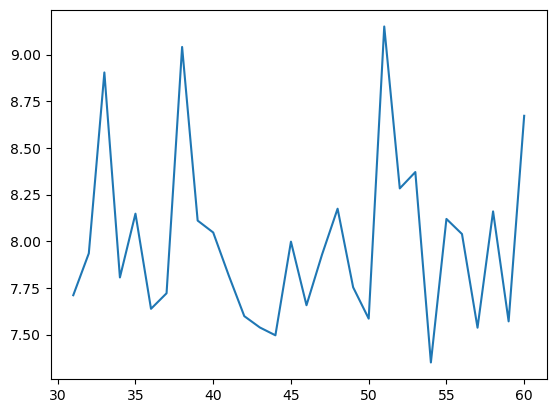

In [33]:
plt.plot(np.arange(31, 61), val_loss)

In [11]:
from xgboost import XGBRegressor

In [13]:
joblib.load('./taxi_analysis/model/xgb_clf.joblib')

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=2, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=11, max_leaves=0, min_child_weight=10,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [26]:
model.load_state_dict(torch.load(os.path.join(save_dir, "44", "checkpoint_44.pth"))['model'])

<All keys matched successfully>

In [29]:
test_results = validate(model, test_dl, MSELoss(), device)
print(test_results)

{'Val Loss': 7.417658396011301, 'Val MAE': 0.974330337449308, 'Val RMSE': 2.7233264584094137, 'Val Time': 32.17125868797302}


Test MAE and RMSE is comparable to that of our deep random forest model. Let's try to use the embedding vectors from this model to create features

In [16]:
import xgboost

In [17]:
xgboost.__version__

'1.6.2'

In [40]:
def extract_embedding(df, num_columns, cat_columns, model):
    model.eval()
    with torch.no_grad():
        embedding_layers = model.module.embedding_layers
        cat_features = torch.LongTensor(df[cat_columns].values)
        cat_features = torch.cat([embedding_layer(cat_feature.squeeze(1)) for 
                                  embedding_layer, cat_feature in
                              zip(embedding_layers, cat_features.split(1, dim=1))], dim=1).numpy()
        return np.concatenate([df[num_columns], cat_features], axis=1), df["Fare"].values


In [43]:
model = model.to('cpu')
X_train, y_train = extract_embedding(train_df, numerical_features, cat_features, model)
X_val, y_val = extract_embedding(val_df, numerical_features, cat_features, model)
X_test, y_test = extract_embedding(test_df, numerical_features, cat_features, model)

In [ ]:
clf = RandomForestRegressor().fit(X_train, y_train)

In [56]:
val_pred = clf.predict(X_val)

print(mean_absolute_error(y_val, val_pred),
      mean_squared_error(y_val, val_pred, squared=False))

0.8387443488280771 2.6243842429764337


In [71]:
svr = LinearSVR().fit(X_train, y_train)
val_pred = svr.predict(X_val)
print(mean_absolute_error(y_val, val_pred),
      mean_squared_error(y_val, val_pred, squared=False))

2.049138643178749 6.0016962632684425


In [72]:
gbr = GradientBoostingRegressor().fit(X_train, y_train)
val_pred = gbr.predict(X_val)
print(mean_absolute_error(y_val, val_pred),
      mean_squared_error(y_val, val_pred, squared=False))

1.4382725033073187 3.5507234029954255


In [74]:
knn = KNeighborsRegressor(n_neighbors=10).fit(X_train, y_train)
val_pred = knn.predict(X_val)
print(mean_absolute_error(y_val, val_pred),
      mean_squared_error(y_val, val_pred, squared=False))

1.3161658264304652 3.035110745600023


In [82]:
lite_rf = RandomForestRegressor(min_samples_split=100, min_samples_leaf=10)\
    .fit(X_train, y_train)
val_pred = lite_rf.predict(X_val)
print(mean_absolute_error(y_val, val_pred),
      mean_squared_error(y_val, val_pred, squared=False))

0.8391453624688305 2.7558097973449134


In [86]:
joblib.dump(lite_rf, "./rf_clf.joblib")

# calculate file size in KB, MB, GB
def convert_bytes(size):
    """ Convert bytes to KB, or MB or GB"""
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024.0:
            return "%3.1f %s" % (size, x)
        size /= 1024.0
        
convert_bytes(os.path.getsize("./rf_clf.joblib"))

'272.9 MB'

In [90]:
lite_rf = RandomForestRegressor(min_samples_split=200, min_samples_leaf=10)\
    .fit(X_train, y_train)

In [91]:
val_pred = lite_rf.predict(X_val)
print(mean_absolute_error(y_val, val_pred),
      mean_squared_error(y_val, val_pred, squared=False))

0.8680985165331295 2.8467401199659013


In [92]:
joblib.dump(lite_rf, "./rf_clf.joblib")

# calculate file size in KB, MB, GB
def convert_bytes(size):
    """ Convert bytes to KB, or MB or GB"""
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024.0:
            return "%3.1f %s" % (size, x)
        size /= 1024.0
        
convert_bytes(os.path.getsize("./rf_clf.joblib"))

'144.1 MB'

A random forest model with minimum samples split 200 (previously 1) and minimum samples leaf 10 (previously 1) will constraint the tree depth but this still amounts to 144.1 MB. Let's try XGBRegressor

In [99]:
xgb = XGBRegressor(max_depth=10).fit(X_train, y_train)
val_pred = xgb.predict(X_val)
print(mean_absolute_error(y_val, val_pred),
      mean_squared_error(y_val, val_pred, squared=False))

0.8256312917417424 2.546297704793532


In [100]:
joblib.dump(xgb, "./xgb_clf.joblib")

# calculate file size in KB, MB, GB
def convert_bytes(size):
    """ Convert bytes to KB, or MB or GB"""
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024.0:
            return "%3.1f %s" % (size, x)
        size /= 1024.0
        
convert_bytes(os.path.getsize("./xgb_clf.joblib"))

'3.9 MB'

Much better file size, so let's hyperparameter tune this and see if it can achieve better performance

In [ ]:
# Import Libraries
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.model_selection import PredefinedSplit

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': np.arange(8, 12, 1)
        }

# Create a list where train data indices are -1 and validation data indices are 0
split_index = [-1 if i < len(X_train) else 0 for i in range(len(X_train) + len(X_val))]

# Use the list to create PredefinedSplit
pds = PredefinedSplit(test_fold = split_index)

# Use PredefinedSplit in GridSearchCV
clf = RandomizedSearchCV(XGBRegressor(),
                         scoring='neg_mean_squared_error',
                         n_jobs=-1, verbose=3,
                         cv=pds,
                         n_iter=50,
                         param_distributions=params)

# Fit with all data
clf.fit(np.concatenate([X_train, X_val]), np.concatenate([y_train, y_val]))

Fitting 1 folds for each of 50 candidates, totalling 50 fits


In [180]:
print(clf.best_params_, clf.best_score_)

{'subsample': 1.0, 'min_child_weight': 10, 'max_depth': 11, 'gamma': 2, 'colsample_bytree': 1.0} -6.451806465685389


In [141]:
best_hyperparams['max_depth'] = int(best_hyperparams['max_depth'])


In [181]:
val_pred = clf.best_estimator_.predict(X_val)
print(mean_absolute_error(y_val, val_pred),
      mean_squared_error(y_val, val_pred, squared=False))

0.7333658440898537 2.1550459328348808


In [183]:
test_pred = clf.best_estimator_.predict(X_test)
print(mean_absolute_error(y_test, test_pred),
      mean_squared_error(y_test, test_pred, squared=False))

0.8125832631384617 2.5187748491277397


In [186]:
len(train_df), len(val_df), len(test_df)

(1732249, 577417, 989857)

In [191]:
joblib.dump(clf.best_estimator_, "./xgb_clf.joblib")

# calculate file size in KB, MB, GB
def convert_bytes(size):
    """ Convert bytes to KB, or MB or GB"""
    for x in ['bytes', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024.0:
            return "%3.1f %s" % (size, x)
        size /= 1024.0
        
convert_bytes(os.path.getsize("./xgb_clf.joblib"))

'3.6 MB'

In [203]:
def calculate_metric(y_true, y_pred, header='Validation'):
    print("{} results as follow:".format(header))
    print("RMSE of {}".format(mean_squared_error(y_true, y_pred, squared=False)))
    print("MAE of {}".format(mean_absolute_error(y_true, y_pred)))
    print("################")

In [205]:
years = [2017, 2018, 2019, 2020]
for year in years:
    df = pd.read_csv(os.path.join(str(year), "./chicago_taxi_cleaned.csv"))
    df.loc[~df["Payment Type"].isin(['Cash', 'Unknown', 'Credit Card', 'Prcard', 'Mobile']), "Payment Type"] = "Unknown"
    df = encode_cat_variables(df)
    df.loc[:, numerical_features] = normalizer.transform(df[numerical_features]).astype('float32')
    X, y = extract_embedding(df, numerical_features, cat_features, model)
    calculate_metric(y, clf.best_estimator_.predict(X), 
                     header="Results for the year {}, XGBoost Regressor".format(year))
    

Results for the year 2017, XGBoost Regressor results as follow:
RMSE of 1.6936738306103143
MAE of 0.5234912611808599
################
Results for the year 2018, XGBoost Regressor results as follow:
RMSE of 1.5568595609347324
MAE of 0.5015219053608052
################
Results for the year 2019, XGBoost Regressor results as follow:
RMSE of 1.6907031295973394
MAE of 0.5646770841432472
################
Results for the year 2020, XGBoost Regressor results as follow:
RMSE of 2.0595317732593084
MAE of 0.6294013718433913
################
